# Timing West and Welford vs. NumPy

In [1]:
import numpy as np 
import nbi_stat as nbi 
import matplotlib.pyplot as plt
import timeit as ti

To make our data, we write a simple function.  We will generate $n$ samples of size $m$ (default 3). 

In [2]:
def gen_data(n,m=3):
    return np.random.default_rng().standard_normal(size=(n,m))

We may want to weight our data, so we make a function to generate weights.  We should be able to create two kinds of weights 

- _frequency_ weights which represents number of counts and are integer valued 
- _non-frequency_ weights which are typically some sort of efficiency weight and are real valued 

Furthermore, the `nbi_stat.West` class allows for _component_ weights.  That is, each dimension of our sample has it's own weight.   However, _NumPy_ only allows for _event_ weights i.e., each sample has _one_ weight.  Thus, for comparison reasons, we will only generate _event_ weights. 

In [3]:
def gen_weights(n,mean=2):
    rg = np.random.default_rng()
    return rg.poisson(mean,size=n) if mean is not None else rg.uniform(size=n)

We want to time full calculation of the means and the covariance.  _NumPy_ does not give us these in one go, so we define a single function to return both 

In [4]:
def np_calc(data,weights=None):
    fweights, aweights = None, None
    if weights is not None:
        if weights.dtype == np.int:
            fweights=weights
        else:
            aweights=weights

    return np.average(data,axis=0,weights=weights), np.cov(data,rowvar=False,fweights=fweights,aweights=aweights)

To calculate using either the `Welford` or `West` classes we wrap in a simple function 

In [5]:
def nbi_calc(data,weights=None):
    def do_weighted(data,weights):
        c = nbi.West(data.shape[1],True,weights.dtype==np.int,False,1)
        
        for o, w in zip(data,weights):
            c.fill(o,w)
        # c.update(data,weights)
        
        return c.mean, c.cov
        
    def do_unweighted(data):
        c = nbi.Welford(data.shape[1],True,1)
        
        for o in data:
            c.fill(o)
        # c.update(data,weights)
        
        return c.mean, c.cov
    
    return do_weighted(data,weights) if weights is not None else do_unweighted(data)

We make a small context manager to time our functions.  This will return the process time spend 

In [6]:
from time import process_time

class benchmark:
    def __enter__(self):
        self.start = process_time()
        return self

    def __exit__(self, *args):
        t = process_time() - self.start
        self.time = t

And then a function to call each of our functions $r$ times, and returning the smallest time 

In [7]:
def measure(func,data,weights=None,repeat=5):
    t = np.inf 
    for _ in range(repeat):
        with benchmark() as b:
            func(data,weights)
        
        t = min(t,b.time)
    
    return t

Next, we investigate the time needed by both functions for different sample sizes. 

In [8]:
def run_n(ns,weighted=False,mean=2):
    np_t  = np.zeros_like(ns,dtype=np.float) 
    nbi_t = np.zeros_like(ns,dtype=np.float)

    for i, n in enumerate(ns):
        data    = gen_data(n)
        weights = gen_weights(n,mean=2) if weighted else None
        nt      = measure(np_calc, data, weights)
        bt      = measure(nbi_calc, data, weights)
    
        print(f'{n:11d}: NumPy={nt:g}  NBI={bt:g}')
    
        np_t [i] = nt 
        nbi_t[i] = bt 
    
    return np_t, nbi_t 

We run the above over some sample sizes

In [9]:
ns    = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
wnp_t, wnbi_t = run_n(ns, True)
np_t,  nbi_t  = run_n(ns)

         10: NumPy=0.000140157  NBI=0.000426676
         50: NumPy=0.000187992  NBI=0.00190599
        100: NumPy=0.000141507  NBI=0.00405267
        500: NumPy=0.000168851  NBI=0.0184372
       1000: NumPy=0.000185188  NBI=0.0395889
       5000: NumPy=0.000546496  NBI=0.155375
      10000: NumPy=0.000618319  NBI=0.308881
      50000: NumPy=0.00515674  NBI=1.60432
     100000: NumPy=0.00911319  NBI=3.29155
         10: NumPy=6.8776e-05  NBI=0.000113361
         50: NumPy=6.746e-05  NBI=0.000503581
        100: NumPy=9.2329e-05  NBI=0.0010146
        500: NumPy=0.000199453  NBI=0.00515418
       1000: NumPy=9.3313e-05  NBI=0.0103616
       5000: NumPy=0.000232886  NBI=0.051578
      10000: NumPy=0.000393392  NBI=0.102469
      50000: NumPy=0.00177678  NBI=0.505446
     100000: NumPy=0.00352744  NBI=1.02366


To get a feel for the time complexity we plot the results. 

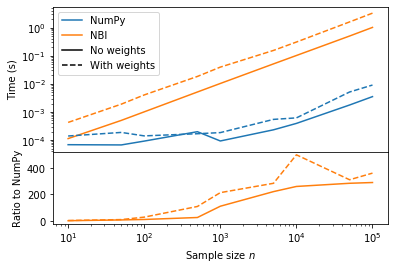

In [10]:
fig, ax = plt.subplots(nrows=2,sharex=True,
                       gridspec_kw=dict(hspace=0,height_ratios=(2,1)))
ax[0].plot(ns, np_t,    '-', color='C0')
ax[0].plot(ns, nbi_t,   '-', color='C1')
ax[0].plot(ns, wnp_t,   '--',color='C0')
ax[0].plot(ns, wnbi_t,  '--',color='C1')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Sample size $n$')
ax[0].set_ylabel('Time (s)')

from matplotlib.lines import Line2D
dnp  = Line2D([],[],color='C0',ls='-',label='NumPy')
dnbi = Line2D([],[],color='C1',ls='-',label='NBI')
dnw  = Line2D([],[],color='k', ls='-',label='No weights')
dw   = Line2D([],[],color='k', ls='--',label='With weights')
la   = [dnp,dnbi,dnw,dw]
ax[0].legend(la,[a.get_label() for a in la]);

ax[1].plot(ns, nbi_t/np_t, '-', color='C1')
ax[1].plot(ns, wnbi_t/wnp_t, '--', color='C1')
ax[1].set_xlabel('Sample size $n$')
ax[1].set_ylabel('Ratio to NumPy');

We would also like to get the a feeling for the time complexity as a function of the data size. 

In [11]:
def run_m(ms,weighted=False,mean=2,n=1000):
    np_t  = np.zeros_like(ms,dtype=np.float) 
    nbi_t = np.zeros_like(ms,dtype=np.float)

    for i, m in enumerate(ms):
        data    = gen_data(n,m)
        weights = gen_weights(n,mean=2) if weighted else None
        nt      = measure(np_calc, data, weights)
        bt      = measure(nbi_calc, data, weights)
    
        print(f'{m:11d}: NumPy={nt:g}  NBI={bt:g}')
    
        np_t [i] = nt 
        nbi_t[i] = bt 
    
    return np_t, nbi_t     

We run the above over some data sizes

In [12]:
ms = [2, 5, 10, 50, 100, 500]
wnp_t, wnbi_t = run_m(ms, True)
np_t,  nbi_t  = run_m(ms)

          2: NumPy=0.000294868  NBI=0.0340346
          5: NumPy=0.000194914  NBI=0.0334578
         10: NumPy=0.000217685  NBI=0.0335532
         50: NumPy=0.00809817  NBI=0.0418613
        100: NumPy=0.00552072  NBI=0.0617396
        500: NumPy=0.0498913  NBI=0.712951
          2: NumPy=0.000100356  NBI=0.00955104
          5: NumPy=9.4266e-05  NBI=0.0100106
         10: NumPy=0.000111299  NBI=0.0104592
         50: NumPy=0.000558382  NBI=0.0363917
        100: NumPy=0.00153479  NBI=0.0403192
        500: NumPy=0.0415237  NBI=0.72191


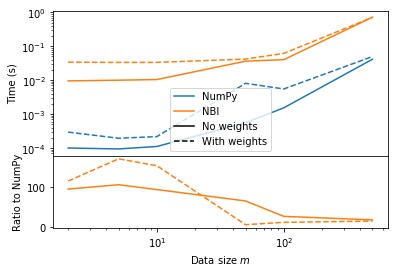

In [13]:
fig, ax = plt.subplots(nrows=2,sharex=True,
                       gridspec_kw=dict(hspace=0,height_ratios=(2,1)))
ax[0].plot(ms, np_t,    '-', color='C0')
ax[0].plot(ms, nbi_t,   '-', color='C1')
ax[0].plot(ms, wnp_t,   '--',color='C0')
ax[0].plot(ms, wnbi_t,  '--',color='C1')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Data size $m$')
ax[0].set_ylabel('Time (s)')

from matplotlib.lines import Line2D
dnp  = Line2D([],[],color='C0',ls='-',label='NumPy')
dnbi = Line2D([],[],color='C1',ls='-',label='NBI')
dnw  = Line2D([],[],color='k', ls='-',label='No weights')
dw   = Line2D([],[],color='k', ls='--',label='With weights')
la   = [dnp,dnbi,dnw,dw]
ax[0].legend(la,[a.get_label() for a in la]);

ax[1].plot(ms, nbi_t/np_t, '-', color='C1')
ax[1].plot(ms, wnbi_t/wnp_t, '--', color='C1')
ax[1].set_xlabel('Data size $m$')
ax[1].set_ylabel('Ratio to NumPy');

In [14]:
%load_ext snakeviz

data    = gen_data(1000)
weights = gen_weights(1000,mean=2)

In [15]:
%%snakeviz

nbi_calc(data,weights)

 
*** Profile stats marshalled to file '/tmp/tmpepx0yyvg'. 
Embedding SnakeViz in this document...


In [16]:
import cProfile as prf
import pstats as ps 

test = lambda: nbi_calc(data)
prf.run('test()', 'profile')
st = ps.Stats('profile')


In [17]:
st.strip_dirs().sort_stats(ps.SortKey.CUMULATIVE).print_callers()

   Ordered by: cumulative time

Function                                                                 was called by...
                                                                             ncalls  tottime  cumtime
{built-in method builtins.exec}                                          <- 
<string>:1(<module>)                                                     <-       1    0.000    0.018  {built-in method builtins.exec}
<ipython-input-16-4ac1ff1901d7>:4(<lambda>)                              <-       1    0.000    0.018  <string>:1(<module>)
<ipython-input-5-dc06212fe6d6>:1(nbi_calc)                               <-       1    0.000    0.018  <ipython-input-16-4ac1ff1901d7>:4(<lambda>)
<ipython-input-5-dc06212fe6d6>:11(do_unweighted)                         <-       1    0.001    0.018  <ipython-input-5-dc06212fe6d6>:1(nbi_calc)
__init__.py:1105(fill)                                                   <-    1000    0.001    0.018  <ipython-input-5-dc06212fe6d6>:11(do_unweigh